Matplotlib is building the font cache; this may take a moment.



=== Comparison of success rates ===
   contract_type               context  4o_mini_success_rate  \
0        erc1155               erc1155                   0.8   
1        erc1155                 erc20                   0.0   
2        erc1155         erc20_erc1155                   0.9   
3        erc1155          erc20_erc721                   0.0   
4        erc1155  erc20_erc721_erc1155                   0.9   
5        erc1155                erc721                   0.0   
6        erc1155        erc721_erc1155                   0.9   
7        erc1155                  none                   0.0   
8          erc20               erc1155                   0.0   
9          erc20                 erc20                   0.9   
10         erc20         erc20_erc1155                   0.9   
11         erc20          erc20_erc721                   0.9   
12         erc20  erc20_erc721_erc1155                   0.8   
13         erc20                erc721                   0.1   
14 

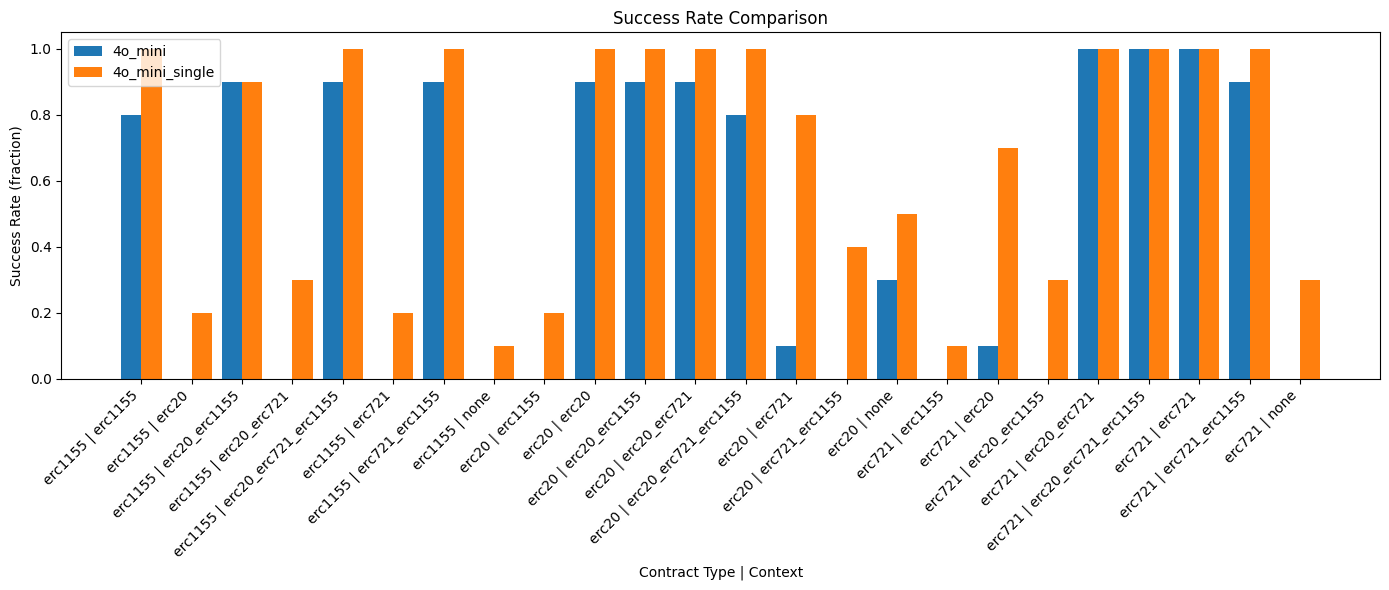

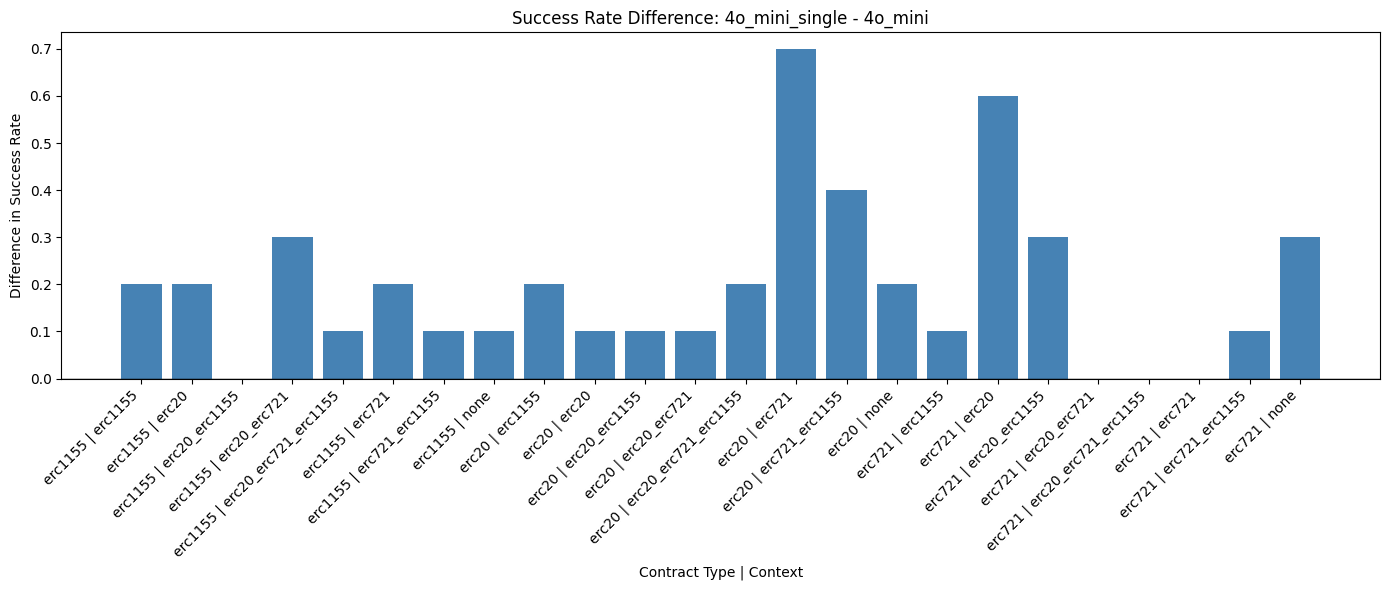

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

def gather_results(base_dir: str, model_name: str) -> pd.DataFrame:
    """
    Recursively finds CSV files under base_dir, computes verification stats for each file,
    and returns a DataFrame with columns:
      [model, contract_type, context, total_runs, success_count, success_rate].
    """
    records = []
    # The directory structure is: results_{assistant}/{requested}/{context}/{requested}_[{context}].csv
    # We'll glob for all CSV files below base_dir
    pattern = os.path.join(base_dir, "**", "*.csv")
    csv_files = glob.glob(pattern, recursive=True)

    for csv_path in csv_files:
        # Parse out the contract_type and context from the path
        parts = csv_path.split(os.sep)
        if len(parts) < 3:
            # If path is too short or not structured, skip it
            continue

        # Typically:
        #   parts[-3] -> contract_type (like 'erc20', 'erc721', 'erc1155')
        #   parts[-2] -> context (like 'erc20', 'erc721', 'none', etc.)
        contract_type = parts[-3]
        context = parts[-2]

        # Read the CSV
        df = pd.read_csv(csv_path)

        # Basic verification stats
        total_runs = len(df)
        success_count = df['verified'].sum() if 'verified' in df.columns else 0
        success_rate = success_count / total_runs if total_runs else 0

        record = {
            "model": model_name,
            "contract_type": contract_type,
            "context": context,
            "total_runs": total_runs,
            "success_count": success_count,
            "success_rate": success_rate
        }
        records.append(record)

    return pd.DataFrame(records)

def compare_models(base_dir_model1: str, model_name_1: str,
                   base_dir_model2: str, model_name_2: str) -> pd.DataFrame:
    """
    Gathers results from two model directories (each containing CSVs),
    merges them on (contract_type, context),
    and returns a DataFrame with:
      [contract_type, context, <model1>_success_rate, <model2>_success_rate, difference].
    """
    df1 = gather_results(base_dir_model1, model_name_1)
    df2 = gather_results(base_dir_model2, model_name_2)

    # Merge on (contract_type, context)
    merged = pd.merge(
        df1, df2,
        on=["contract_type", "context"],
        how="outer",
        suffixes=(f"_{model_name_1}", f"_{model_name_2}")
    )

    # Rename success_rate columns for clarity
    merged = merged.rename(columns={
        f"success_rate_{model_name_1}": f"{model_name_1}_success_rate",
        f"success_rate_{model_name_2}": f"{model_name_2}_success_rate"
    })

    # Fill missing success rates with 0
    merged[f"{model_name_1}_success_rate"] = merged[f"{model_name_1}_success_rate"].fillna(0)
    merged[f"{model_name_2}_success_rate"] = merged[f"{model_name_2}_success_rate"].fillna(0)

    # Create a difference column (model2 - model1)
    merged["difference"] = (
        merged[f"{model_name_2}_success_rate"] -
        merged[f"{model_name_1}_success_rate"]
    )

    return merged

def plot_comparison(df: pd.DataFrame, model_name_1: str, model_name_2: str):
    df = df.sort_values(by=["contract_type", "context"]).reset_index(drop=True)

    # Combine contract_type and context into a single line
    labels = df["contract_type"] + " | " + df["context"]
    x = range(len(df))

    # ======== FIGURE 1: Grouped Bar Chart ========
    plt.figure(figsize=(14, 6))  # increase width
    width = 0.4

    plt.bar([i - width/2 for i in x], df[f"{model_name_1}_success_rate"], 
            width=width, label=model_name_1)
    plt.bar([i + width/2 for i in x], df[f"{model_name_2}_success_rate"], 
            width=width, label=model_name_2)

    # Rotate labels, align right
    plt.xticks(ticks=x, labels=labels, rotation=45, ha="right")
    plt.title("Success Rate Comparison")
    plt.xlabel("Contract Type | Context")
    plt.ylabel("Success Rate (fraction)")
    plt.legend()
    plt.tight_layout()

    # ======== FIGURE 2: Difference Bar Chart ========
    plt.figure(figsize=(14, 6))
    plt.bar(x, df["difference"], color="steelblue")
    plt.axhline(y=0, color="black", linewidth=1)
    plt.xticks(ticks=x, labels=labels, rotation=45, ha="right")
    plt.title(f"Success Rate Difference: {model_name_2} - {model_name_1}")
    plt.xlabel("Contract Type | Context")
    plt.ylabel("Difference in Success Rate")
    plt.tight_layout()

    plt.show()

def main():
    """
    Adjust the base_dir_4o_mini and base_dir_4o_mini_single paths as needed.
    This script will:
      1) Gather stats for both models,
      2) Merge them into a single DataFrame,
      3) Print & save that table to model_comparison.csv,
      4) Plot two bar charts side by side for better visualization.
    """
    # Example directories
    base_dir_4o_mini = "results_4o_mini"
    base_dir_4o_mini_single = "results_4o_mini_single"

    df_comparison = compare_models(
        base_dir_4o_mini,        "4o_mini",
        base_dir_4o_mini_single, "4o_mini_single"
    )

    # Print the table
    print("\n=== Comparison of success rates ===")
    print(df_comparison[[
        "contract_type",
        "context",
        "4o_mini_success_rate",
        "4o_mini_single_success_rate",
        "difference"
    ]])

    # Optionally save to CSV
    csv_name = "model_comparison.csv"
    df_comparison.to_csv(csv_name, index=False)
    print(f"\nSaved comparison to '{csv_name}'")

    # Generate plots
    plot_comparison(df_comparison, "4o_mini", "4o_mini_single")

if __name__ == "__main__":
    main()


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy.stats import chi2_contingency

def load_model_data(model_name):
    """Load all CSV files for a specific model"""
    if model_name == '4o_mini': 
        csv_files = ['results_4o_mini/erc20/erc721/erc20_[erc721].csv', 'results_4o_mini/erc20/none/erc20_[none].csv', 'results_4o_mini/erc20/erc721_erc1155/erc20_[erc721_erc1155].csv', 'results_4o_mini/erc20/erc1155/erc20_[erc1155].csv', 'results_4o_mini/erc721/erc20/erc721_[erc20].csv', 'results_4o_mini/erc721/none/erc721_[none].csv', 'results_4o_mini/erc721/erc20_erc1155/erc721_[erc20_erc1155].csv', 'results_4o_mini/erc721/erc1155/erc721_[erc1155].csv', 'results_4o_mini/erc1155/erc20/erc1155_[erc20].csv', 'results_4o_mini/erc1155/erc721/erc1155_[erc721].csv', 'results_4o_mini/erc1155/erc20_erc721/erc1155_[erc20_erc721].csv', 'results_4o_mini/erc1155/none/erc1155_[none].csv']
    else: 
        csv_files = ['results_4o_mini_single/erc20/erc721/erc20_[erc721].csv', 'results_4o_mini_single/erc20/none/erc20_[none].csv', 'results_4o_mini_single/erc20/erc721_erc1155/erc20_[erc721_erc1155].csv', 'results_4o_mini_single/erc20/erc1155/erc20_[erc1155].csv', 'results_4o_mini_single/erc721/erc20/erc721_[erc20].csv', 'results_4o_mini_single/erc721/none/erc721_[none].csv', 'results_4o_mini_single/erc721/erc20_erc1155/erc721_[erc20_erc1155].csv', 'results_4o_mini_single/erc721/erc1155/erc721_[erc1155].csv', 'results_4o_mini_single/erc1155/erc20/erc1155_[erc20].csv', 'results_4o_mini_single/erc1155/erc721/erc1155_[erc721].csv', 'results_4o_mini_single/erc1155/erc20_erc721/erc1155_[erc20_erc721].csv', 'results_4o_mini_single/erc1155/none/erc1155_[none].csv']

    print(csv_files)
    
    all_data = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            context = os.path.basename(file).split('_[')[1].replace('].csv', '')
            df['model'] = model_name
            df['context'] = context
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    return pd.concat(all_data, ignore_index=True)

def compare_success_rates(base_df, tuned_df):
    """Compare and visualize success rates between models"""
    combined = pd.concat([base_df, tuned_df])
    
    success_rates = combined.groupby('model')['verified'].agg(['mean', 'count', 'sum'])
    success_rates.columns = ['success_rate', 'total_runs', 'successes']
    
    # Corrected contingency table
    contingency_table = [
        [
            success_rates.loc['4o_mini', 'successes'], 
            success_rates.loc['4o_mini', 'total_runs'] - success_rates.loc['4o_mini', 'successes']
        ],
        [
            success_rates.loc['4o_mini_single', 'successes'], 
            success_rates.loc['4o_mini_single', 'total_runs'] - success_rates.loc['4o_mini_single', 'successes']
        ]
    ]
    
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y='verified', data=combined, 
                estimator=lambda x: sum(x)/len(x), errorbar=None)
    plt.title('Verification Success Rate Comparison')
    plt.ylabel('Success Rate')
    plt.xlabel('Model')
    plt.ylim(0, 1)
    plt.text(0.5, 0.9, f'p-value: {p:.4f}', ha='center', va='center')
    
    output_dir = 'comparison_results'
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'success_rate_comparison.png'))
    success_rates.to_csv(os.path.join(output_dir, 'success_stats.csv'))
    
    return success_rates, p

if __name__ == '__main__':
    base_model = load_model_data('4o_mini')
    tuned_model = load_model_data('4o_mini_single')
    results, p_value = compare_success_rates(base_model, tuned_model)
    
    print("Success Rate Comparison:")
    print(results)
    print(f"\nStatistical significance (p-value): {p_value:.4f}")
    if p_value < 0.05:
        print("The difference is statistically significant (p < 0.05)")
    else:
        print("The difference is not statistically significant")

ModuleNotFoundError: No module named 'scipy'